# Full detector response

The detector response provides us with the the following information:
- The effective area at given energy for given direction. This allows us to convert from counts to physical quantities like flux
- The expected distribution of measured energy and other reconstructed quantities. This allows us to account for all sorts of detector effects when we do our analysis.

This tutorial will show you how to handle detector response and extrat useful information from it:

## Opening a full detector response

The response of the instrument in encoded in a series of matrices cointained in a file. you can open the file like this:

In [2]:
%%capture
from cosipy import test_data

response_path = test_data.path / "test_full_detector_response.h5"

In [4]:
from cosipy.response import FullDetectorResponse

response = FullDetectorResponse.open(response_path)

print(response.filename)

response.close()

/Users/eneights/work/COSI/data_challenge_2/cosipy/cosipy/test_data/test_full_detector_response.h5


Or if you don't want to worry about closing the file, use a context manager statement:

In [5]:
with FullDetectorResponse.open(response_path) as response:

    print(repr(response))

FILENAME: '/Users/eneights/work/COSI/data_challenge_2/cosipy/cosipy/test_data/test_full_detector_response.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 12
    NSIDE: 1
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [150.0 keV, 220.0 keV, 325.0 keV, 480.0 keV, 520.0 keV, 765.0 keV, 1120.0 keV, 1650.0 keV, 2350.0 keV, 3450.0 keV, 5000.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [150.0 keV, 220.0 keV, 325.0 keV, 480.0 keV, 520.0 keV, 765.0 keV, 1120.0 keV, 1650.0 keV, 2350.0 keV, 3450.0 keV, 5000.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 30
    EDGES: [0.0 deg, 6.0 deg, 12.0 deg, 18.0 deg, 24.0 deg, 30.0 deg, 36.0 deg, 42.0 deg, 48.0 deg, 54.0 deg, 60.0 deg, 66.0 deg, 72.0 deg, 78.0 deg, 84.0 deg, 90.0 deg, 96.0 de

Although opening a detector response does not load the matrices, it loads all the header information above. This allows us to pass it around for various analysis at a very low cost.

## Detector response matrix

The full --i.e. all-sky-- detector response is encoded in a HEALPix grid. For each pixel there is a multidimensional matrix describing the response of the instrument for that particular direction in the spacefraft coordinates. For this response has the following grid:

In [6]:
import numpy as np
import astropy.units as u

with FullDetectorResponse.open(response_path) as response:
    
    print(f"NSIDE = {response.nside}")
    print(f"SCHEME = {response.scheme}")
    print(f"NPIX = {response.npix}")
    print(f"Pixel size = {np.sqrt(response.pixarea()).to(u.deg):.2f}")

NSIDE = 1
SCHEME = RING
NPIX = 12
Pixel size = 58.63 deg


To retrieve the detector response matrix for a given pixel simply use the `[]` operator

In [7]:
with FullDetectorResponse.open(response_path) as response:
    
    print(f"Pixel 0 centered at {response.pix2skycoord(0)}")
    drm = response[0]

Pixel 0 centered at <SkyCoord (SpacecraftFrame: attitude=None, obstime=None, location=None): (lon, lat) in deg
    (45., 41.8103149)>


Or better, get the interpolated matrix for a given direction. In this case, for the on-axis response:

In [8]:
from scoords import SpacecraftFrame
from astropy.coordinates import SkyCoord

with FullDetectorResponse.open(response_path) as response:
    
    drm = response.get_interp_response(SkyCoord(lon = 0*u.deg, lat = 0*u.deg, frame = SpacecraftFrame()))

The matrix has multiple dimensions, including real photon initial energy, the measured energy, the Compton data space, and possibly other:

In [9]:
drm.axes.labels

array(['Ei', 'Em', 'Phi', 'PsiChi', 'SigmaTau', 'Dist'], dtype='<U8')

However, one of the most common operation is to get the effective area and the energy dispersion matrix. This is encoded in a reduced detector response, which is the projection of the full matrix into the initial and measured energy axes:

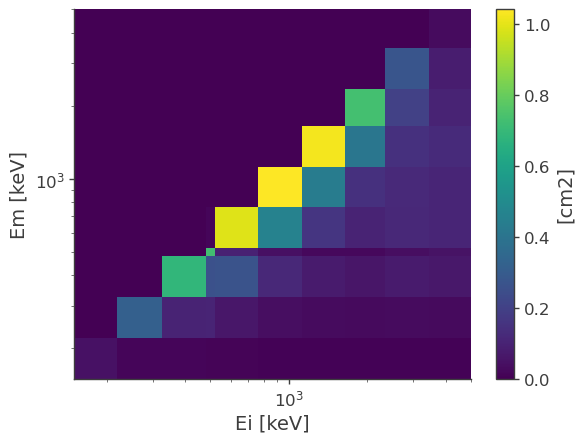

In [10]:
drm.get_spectral_response().plot();

You can further project it into the initial energy to get the effective area:

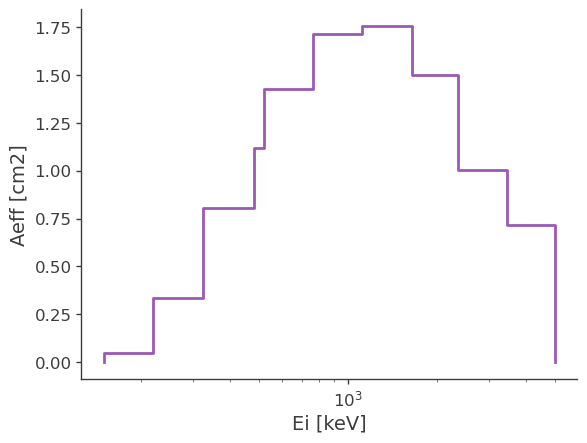

In [11]:
ax,plot = drm.get_effective_area().plot();

ax.set_ylabel(f'Aeff [{drm.unit}]');

Get the interpolated effective area

In [12]:
drm.get_effective_area(511*u.keV)

<Quantity 1.14671213 cm2>

Or the energy dispersion matrix

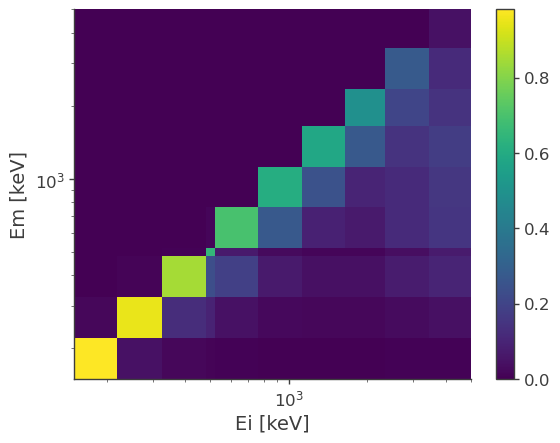

In [13]:
drm.get_dispersion_matrix().plot();

## Point source response

Once we have the response, the next step is usually to get the expected counts for a specific source. However, it is not trivial for the case of a spacecraft because the response we have here is the detector response. This response records the detector effects to given points viewed from the reference frame attached to the spacecraft (SC).

A source with a fixed position on the sky is moving from the perspective of the spacecraft (detector). Therefore, we need to convert the coordinate of a source to the reference frame, which results in a moving point viewed the spacecraft. By convolving the trajectory of the source in the spacecraft frame with the detector response, we will get the so-called point source response.

### Load modules

In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from mhealpy import HealpixMap
import matplotlib.pyplot as ply
import pandas as pd
from astropy.time import Time
from pathlib import Path

from scoords import Attitude
from cosipy.response import FullDetectorResponse
from scoords import SpacecraftFrame
from cosipy.spacecraftfile import SpacecraftFile
from cosipy import test_data
from cosipy.util import fetch_wasabi_file
from histpy import Histogram
import gc

### Read and plot the orientation

In [ ]:
%%capture
# download orientation file ~684.38 MB
fetch_wasabi_file("COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori")

In [2]:
# read the full oritation
ori_full = SpacecraftFile.parse_from_file("20280301_3_month.ori")

# Define a time interval you want to calculate the point source response
ori = ori_full.source_interval(Time(1835487300, format = "unix"), Time(1835488300, format = "unix"))

# clear redundant data from RAM
del ori_full
_ = gc.collect()

Text(0, 0.5, 'Latitude [deg]')

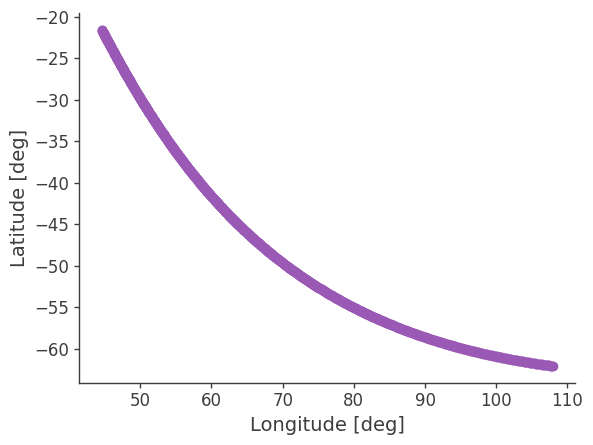

In [3]:
# you can plot the pointings from the constructed astropy.Skycoord object at the z direction, 
plt.plot(ori.z_pointings.l.deg, ori.z_pointings.b.deg, "o")
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")

### Calculate the source movement in the SC frame

In [4]:
# define the target coordinates (Crab)
target_coord = SkyCoord(184.5551, -05.7877, unit = "deg", frame = "galactic")

# get the target movement in the reference frame attached to the detector
target_in_sc_frame = ori.get_target_in_sc_frame(target_name = "Crab", target_coord = target_coord)

Now converting to the Spacecraft frame...
Conversion completed!


Text(0, 0.5, 'Latotiude [deg]')

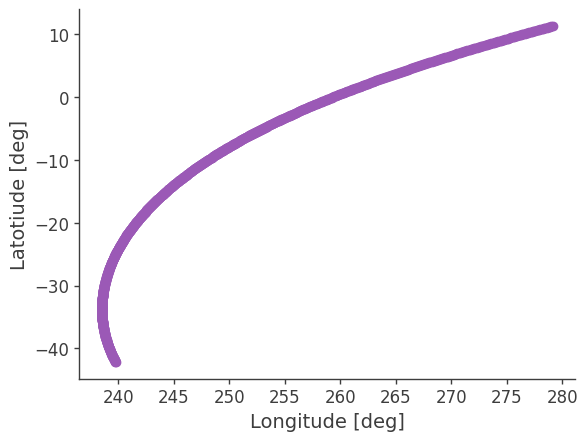

In [5]:
# plot the movement of Crab in the reference frame attached to the detector
plt.plot(target_in_sc_frame.lon.deg, target_in_sc_frame.lat.deg,"o")
plt.xlabel("Longitude [deg]")
plt.ylabel("Latotiude [deg]")

### Get dwell time map

In [ ]:
%%capture
# download response file ~839.62 MB
fetch_wasabi_file("COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip")

# unzip the response file
shutil.unpack_archive("SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip")

# delete the zipped response to save space
os.remove("SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip")

In [9]:
# define the response file
response_file_dir = "SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5"

# get the exposure map (dwell time map)
dwell_time_map = ori.get_dwell_map(response = response_file_dir, save = True)

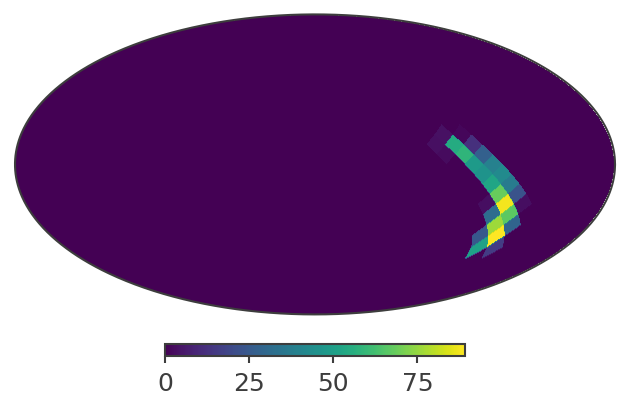

In [7]:
# plot the dwell time map in detector coordinates (top is zenith)

_,ax = dwell_time_map.plot(coord = SpacecraftFrame(attitude = Attitude.identity()));

### Get the point source response

We can now convolve the exposure map with the full detector response, and get a PointSourceResponse

In [8]:
_ =  ori.get_psr_rsp()

Getting the effective area ...
Getting the energy redistribution matrix ...


In [37]:
#If you already have the dwell time map, you don't need to run all the steps above, 
# simply load the dwell time map here by speficifying the dwell_map parameter.

# _ =  ori.get_psr_rsp(response =response_file_dir,
#                      dwell_map = "CygX1_DwellMap.fits")

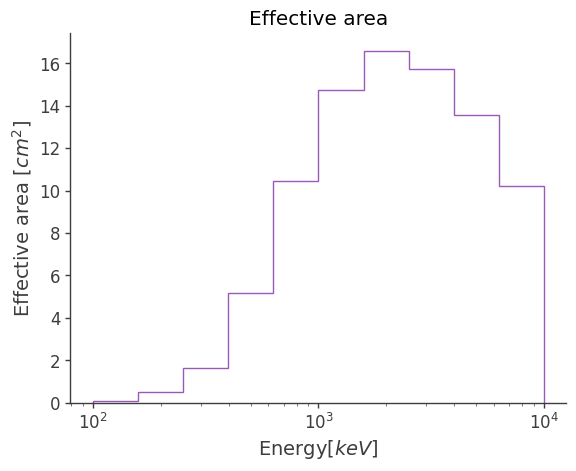

In [10]:
# plot get and the effective area
# the arf file can be read by XSPEC
ori.get_arf()
ori.plot_arf()

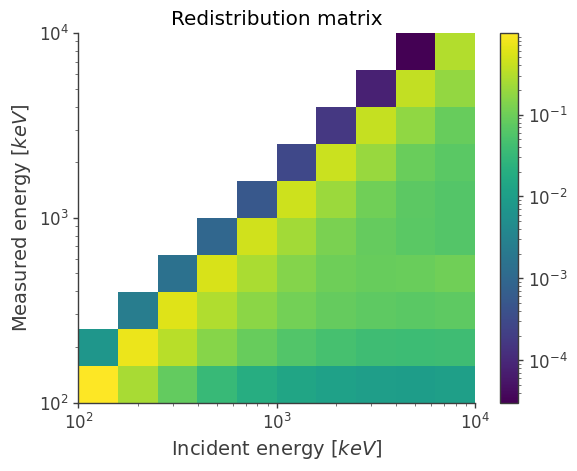

In [11]:
# get and plot the energy redistribution matrix
# the rmf file can be read by XSPEC
ori.get_rmf()
ori.plot_rmf()

## Point source response in inertial coordinates

In the previous example we obtained the response for a point source as seen in the reference frame attached to the spacecraft (SC) frame. As the spacecraft rotates, a fixed source in the sky is seen by the detector from multiple direction, so binnind the data on the spacecraft coordinate, without binning it simultenously in time, can wash out the signal. As shown in this section, we can instead rotate the response and convolve it the attitude history of the spacecraft, resulting in a point source response with a Compton data space binned in inertial coordinates.

For this example we'll use the following files. The links point to wasabi.
- [SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip](https://console.wasabisys.com/file_manager/cosi-pipeline-public/COSI-SMEX/DC2/Responses)
- [20280301_3_month.ori](https://console.wasabisys.com/file_manager/cosi-pipeline-public/COSI-SMEX/DC2/Data/Orientation?region=us-west-1)

Uncompress the response and place both of them in any folder that you want and edit the following variable to point there:

In [1]:
from pathlib import Path

data_folder = Path("/Users/imartin5/cosi/scratch/inertial_coords/data")

First, let's read in the detector response, which will serve as reference for the rest of the code

In [2]:
from cosipy.response import FullDetectorResponse

response_filename = str(data_folder/"SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5")

response = FullDetectorResponse.open(response_filename)

16:15:49 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=729037;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=510862;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=866980;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=900733;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

16:15:50 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=969324;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=275981;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

16:15:50 INFO      Starting 3ML!                                                                     ]8;id=468705;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=129083;file:///Users/imartin5/software/threeML/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=156665;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=856642;file:///Users/imartin5/software/threeML/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=944775;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=755292;file:///Users/imartin5/software/threeML/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=621067;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=142478;file:///Users/imartin5/software/threeML/threeML/__init__.py#40\40]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=663560;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=600882;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=517663;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=631625;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py#1357\1357]8;;\

16:15:51 WARNING   PyGMO is not available                                                      ]8;id=373995;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=827247;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py#1369\1369]8;;\

16:15:51 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=140026;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=50805;file:///Users/imartin5/software/threeML/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=978351;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=569131;file:///Users/imartin5/software/threeML/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=682642;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=173889;file:///Users/imartin5/software/threeML/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

16:15:52 WARNING   No fermitools installed                                              ]8;id=349658;file:///Users/imartin5/software/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=725875;file:///Users/imartin5/software/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

16:15:52 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=442907;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=290984;file:///Users/imartin5/software/threeML/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=617156;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=733162;file:///Users/imartin5/software/threeML/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=54483;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=817393;file:///Users/imartin5/software/threeML/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

Next, let's read in the spacecraft orientation file that contains the attitude information versus time:

In [3]:
from cosipy import SpacecraftFile

ori = SpacecraftFile.parse_from_file(data_folder/"20280301_3_month.ori")

Since the spacecraft can have the same orientation multiple times, we avoid to rotate the response multiple times by creating a histogram that keeps track of the attitude information. This is the "spacecraft attitude map", and is a 4D matrix that contain the amount of time that the `x` and `y` SC axis were pointing at a given location in inertial coordinates -e.g. galactic.

In [4]:
scatt_map = ori.get_scatt_map(nside = response.nside * 2, coordsys = 'galactic')


WARNING ErfaWarning: ERFA function "utctai" yielded 7979956 of "dubious year (Note 3)"



This is a how the 2D projections looks like

(<MollviewSubplot: >, <matplotlib.image.AxesImage at 0x1316a61c0>)

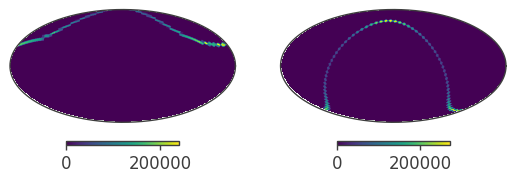

In [5]:
from matplotlib import pyplot as plt

fig,axes = plt.subplots(ncols = 2, subplot_kw = {'projection':'mollview'})

scatt_map.project('x').plot(axes[0])
scatt_map.project('y').plot(axes[1])

Now we can let cosipy perform the convolution with `` and get the point source response:

In [6]:
%%time

from astropy.coordinates import SkyCoord

coord = SkyCoord.from_name('Crab').galactic

psr = response.get_point_source_response(coord = coord, scatt_map = scatt_map)

CPU times: user 47.1 s, sys: 6.18 s, total: 53.3 s
Wall time: 55.7 s


This is how a slice of the response looks like in galactic coordinates:

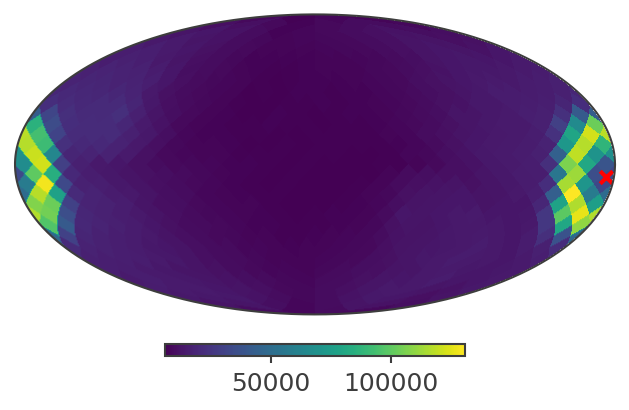

In [7]:
psichi_slice = psr.slice[{'Ei':4, 'Phi':4}].project('PsiChi')

ax,plot = psichi_slice.plot(ax_kw = {'coord':'G'})

ax.scatter([coord.l.deg], [coord.b.deg], transform = ax.get_transform('world'), marker = 'x', color = 'red')

And here in ICRC (RA/Dec), the default coordinates for plot()

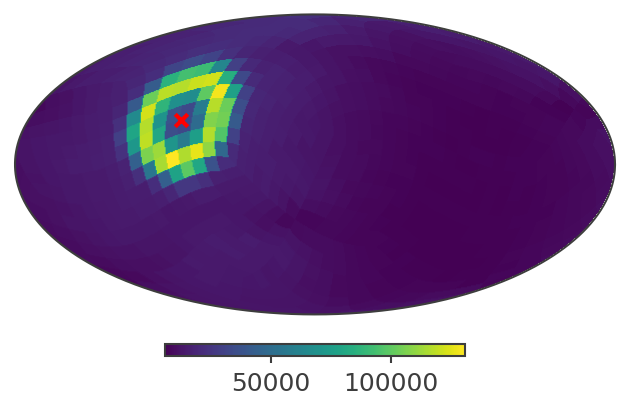

In [8]:
ax,plot = psichi_slice.plot()

ax.scatter([coord.icrs.ra.deg], [coord.icrs.dec.deg], transform = ax.get_transform('world'), marker = 'x', color = 'red')

You can also used it the same way as a point source response obtained from a exposure map. e.g.

Text(0, 0.5, 'Expected counts')

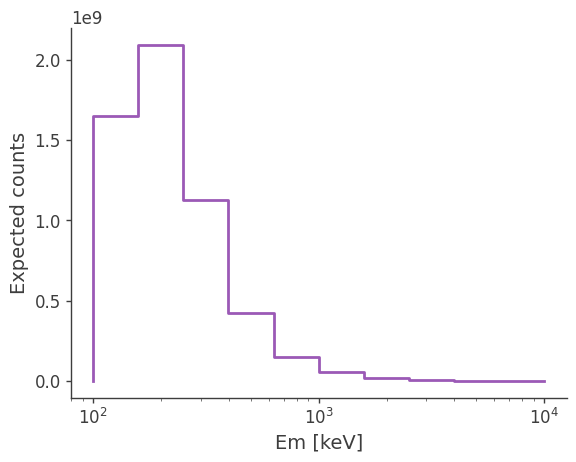

In [9]:
from astropy import units as u
from threeML import Model, Powerlaw
from astropy.units import Quantity

index = -3
K = 10**-3 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV

spectrum = Powerlaw()
spectrum.index.value = index
spectrum.piv.value = piv.value
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit
    
expectation = psr.get_expectation(spectrum)

ax, plot = expectation.project('Em').plot()

ax.set_ylabel('Expected counts')

Lastly, you can obtain the response for multiple coordinstes at once. This can be useful for e.g. imaging

In [10]:
%%time

from mhealpy import HealpixBase

gal_grid = HealpixBase(nside = 16, coordsys = 'galactic')

gal_coords = gal_grid.pix2skycoord(range(gal_grid.npix))

response.get_point_source_response(coord = gal_coords[10:12], scatt_map = scatt_map)

CPU times: user 1min, sys: 6.69 s, total: 1min 6s
Wall time: 1min 8s


(<cosipy.response.PointSourceResponse.PointSourceResponse at 0x132137220>,
 <cosipy.response.PointSourceResponse.PointSourceResponse at 0x1321376d0>)

You can see that getting the response for two coordinste takes less than twice the time for a single one. 